In [ ]:
'''
This notebook generates the figures for PBMC dataset.
 - Figure 6 : The confusion matrix of the melanoma dataset for the unknown cell-type identification task
 - Supplementary Table 1 : LOF_performance. The unknown cell type classification result of melanoma testing dataset
 - Supplementary Figure 3 :  The confusion matrix of melanoma dataset provided by Scibet
'''

In [1]:
#!/usr/bin/env python

# importing default libraries
import os
import sys
# sys.path.append('./')
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import config as src
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
# from sklearn.neighbors import LocalOutlierFactor
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import glob
TINY_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=12) # fontsize of the axes title
plt.rc('axes', labelsize=12) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('legend', title_fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE) # fontsize of the figure title

In [3]:
from sklearn.neighbors import LocalOutlierFactor
def calculate_threshold(encoding_with_seen, encoding_with_unseen, y_with_seen, y_with_unseen):
    lof = LocalOutlierFactor(novelty=True)
    lof.fit(encoding_with_seen)

    df_score_unseen = pd.concat([ y_with_unseen, pd.DataFrame(lof.score_samples(encoding_with_unseen), columns=['score'])], axis=1)
    df_score_seen = pd.concat([ y_with_seen, pd.DataFrame(lof.score_samples(encoding_with_seen), columns=['score'])], axis=1)

    # Calculated threshold value
    threshold = np.mean(df_score_seen.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                        - 1*df_score_seen.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
    print('Threshold value from reference dataset, ', threshold)
    return threshold, df_score_seen, df_score_unseen

## MELANOMA

In [4]:
# loading dataset
loc_output = './reports/retrieval_lof/exper_melanoma'

df_query = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
df_reference = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')

X_query = df_query.iloc[:, :-1].values
y_ground_truth_query = df_query.iloc[:, -1:]

X_reference = df_reference.iloc[:, :-1].values
y_ground_truth_reference = df_reference.iloc[:, -1:]

ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y_ground_truth_reference.values).toarray()
X_train, X_test, y_train, y_test = train_test_split(X_reference, y_ground_truth_reference, test_size=0.3, random_state=91, stratify=y_ohe)

In [5]:
# the order of the legend of the plot
order_plot = list(np.unique(y_ground_truth_reference))
seen_label = dict(zip(order_plot, range(len(order_plot))))
order_plot.append('Neg.cell')
unseen_label = dict(zip(order_plot, range(len(order_plot))))
print(seen_label)
print(unseen_label)

{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4}
{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4, 'Neg.cell': 5}


## LOADING MODEL

In [6]:
# loading 1-layer design
model_name = 'circuits_1_layer'
tuning = 'tuningFalse'
gene_space='filtergeneFalse'
split='None'

model , model_encoding = src.loading_model(f'./models/exper_melanoma/{split}_{tuning}_{gene_space}/design_{model_name}_reference_log1p_Adam_relu_0.h5', -1)
model_encoding.summary()

Loaded model!! ./models/exper_melanoma/None_tuningFalse_filtergeneFalse/design_circuits_1_layer_reference_log1p_Adam_relu_0.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 17994)]           0         
_________________________________________________________________
layer1 (Dense)               (None, 1210)              21773950  
Total params: 21,773,950
Trainable params: 21,773,950
Non-trainable params: 0
_________________________________________________________________


In [7]:
# getting learned information
encoding_query = model_encoding.predict(X_query)
encoding_reference = model_encoding.predict(X_reference)

encoding_training = model_encoding.predict(X_train)
encoding_testing = model_encoding.predict(X_test)

print(encoding_query.shape)
print(encoding_reference.shape)

(3412, 1210)
(2761, 1210)


In [8]:
# calculating threshold value
threshold, df_lof_reference, df_lof_query = calculate_threshold(encoding_with_seen=encoding_reference
                                                                , encoding_with_unseen=encoding_query
                                                                , y_with_seen=y_ground_truth_reference
                                                                , y_with_unseen=y_ground_truth_query)

Threshold value from reference dataset,  -1.5387666955000876


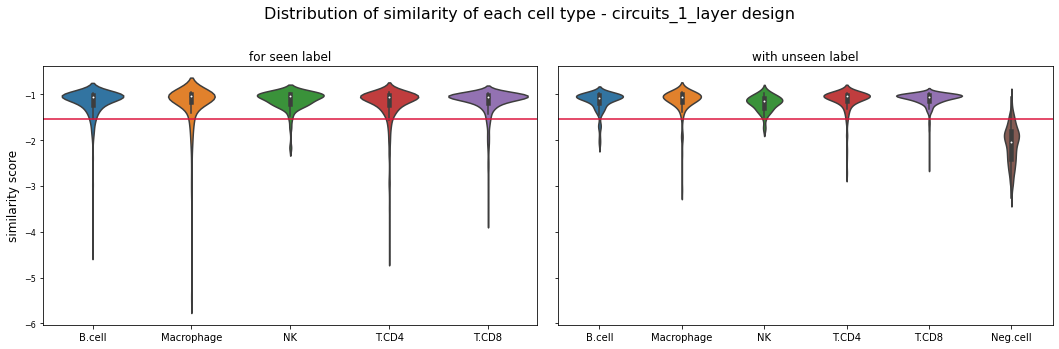

In [9]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_lof_reference, ax=axes[0], order=seen_label)
sns.violinplot(x="cell_type", y="score", data=df_lof_query, ax=axes[1], order=unseen_label)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of each cell type - '+model_name+' design')
plt.tight_layout();

plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}.png'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}.pdf'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}.tiff'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)

In [10]:
df_lof_query['threshold'] = 'above'
df_lof_query.loc[df_lof_query['score']<=threshold, 'threshold'] = 'below'
df_lof_query[df_lof_query['cell_type']=='Neg.cell'].groupby('threshold').size()  / len(df_lof_query[df_lof_query['cell_type']=='Neg.cell'])

threshold
above    0.080341
below    0.919659
dtype: float64

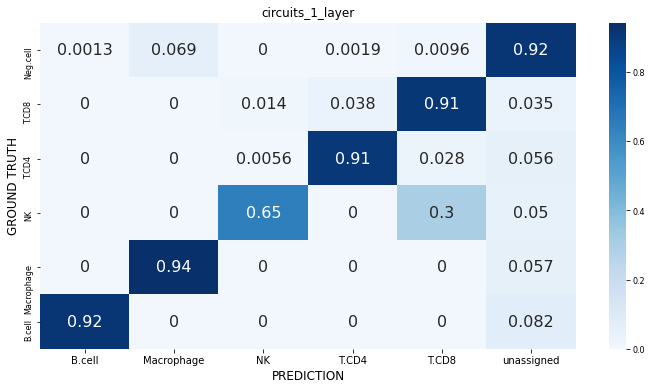

In [11]:
# calling unassigned_with_threshold function to assign the cell type as unassigned if the samples are below the threshold
df_pred_truth = src.unassigned_with_threshold(y_with_seen=y_ground_truth_reference
                                   , y_with_unseen=y_ground_truth_query
                                   , X_with_unseen=X_query
                                   , lof_unseen=df_lof_query
                                   , model=model
                                   , threshold=threshold)

df_logo_crosstab = pd.crosstab(df_pred_truth['cell_type'], df_pred_truth['pred'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)
df_logo_crosstab

src.get_confusion_matrix(df_logo_crosstab)
plt.title(f'{model_name}');

plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.png'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.pdf'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.tiff'), dpi=300, bbox_inches = 'tight', pad_inches=0.1)

In [12]:
# supplementary table 1
df_percentage = pd.DataFrame((df_lof_query.groupby(['threshold','cell_type']).size() / df_lof_query.groupby(['cell_type']).size())*100
                      , columns=['percentage'])
df_count = pd.DataFrame(df_lof_query.groupby(['threshold','cell_type']).size()
                      , columns=['count'])
result = pd.concat([df_count, df_percentage], axis=1).reset_index()
result.to_csv(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}_result.csv'), index=False)
result

,threshold,cell_type,count,percentage
0,above,B.cell,229,93.469388
1,above,Macrophage,119,94.444444
2,above,NK,27,96.428571
3,above,Neg.cell,179,8.034111
4,above,T.CD4,243,94.552529
5,above,T.CD8,512,96.969697
6,below,B.cell,16,6.530612
7,below,Macrophage,7,5.555556
8,below,NK,1,3.571429
9,below,Neg.cell,2049,91.965889


## SCIBET RESULT

In [13]:
scibet_result = pd.read_csv('./data/scibet_result.txt',sep='\t')
scibet_result['prd_with_threshold'] = scibet_result['prd']
scibet_result.loc[scibet_result['c_score']<=0.45, 'prd_with_threshold'] = 'unassigned'

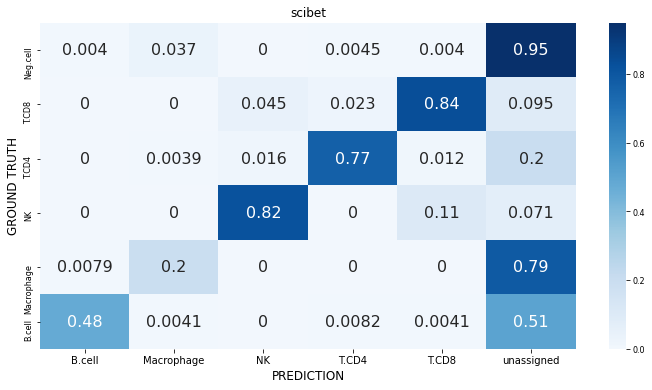

In [14]:
# Supplementary Figure 3 :  The confusion matrix of melanoma dataset provided by Scibet
df_logo_crosstab = pd.crosstab(scibet_result['ori'], scibet_result['prd_with_threshold'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)

src.get_confusion_matrix(df_logo_crosstab)
plt.title(f'scibet');

plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.png'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.pdf'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.tiff'), dpi=300, bbox_inches = 'tight')